<a href="https://colab.research.google.com/github/sulaimanbehzad/Classifying-Images/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiers
The purpose of this project is to train two classifiers:
1. Captions classifier
2. Image classifier

In [3]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import imageio
import cv2

import tensorflow as tf
from keras import utils
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from PIL import Image as pil_image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

VGG16

## Part 2: Image Classifier

We will use VGG16 model to obtain a vector representation of the model

In [22]:
img_width, img_height = 150, 150

path_train_sentences = r'/content/drive/MyDrive/dataset/train/images'   
path_test_sentences =  r'/content/drive/MyDrive/dataset/test/images'
nb_train_samples = 532
nb_validation_samples = 380
epochs = 10
batch_size = 4


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [23]:


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten(input_shape=input_shape))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [24]:
path_train_sentences = r'/content/drive/MyDrive/dataset/train/images'   
path_test_sentences =  r'/content/drive/MyDrive/dataset/test/images'


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        path_train_sentences,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        path_test_sentences,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 532 images belonging to 19 classes.
Found 380 images belonging to 19 classes.


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=532 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=380 // batch_size)
model.save_weights('first_try.h5') 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
133/133 [==============================] - 36s 263ms/step - loss: -151470003.8171 - accuracy: 0.0634 - val_loss: -3062306560.0000 - val_accuracy: 0.0526
Epoch 2/10
133/133 [==============================] - 35s 261ms/step - loss: -9043781123.8209 - accuracy: 0.0538 - val_loss: -49600626688.0000 - val_accuracy: 0.0526
Epoch 3/10
133/133 [==============================] - 34s 254ms/step - loss: -85454090759.6418 - accuracy: 0.0460 - val_loss: -268911443968.0000 - val_accuracy: 0.0526
Epoch 4/10
133/133 [==============================] - 34s 254ms/step - loss: -387811685146.7463 - accuracy: 0.0590 - val_loss: -932050436096.0000 - val_accuracy: 0.0526
Epoch 5/10
133/133 [==============================] - 34s 252ms/step - loss: -1227000289249.4329 - accuracy: 0.0480 - val_loss: -2448842817536.0000 - val_accuracy: 0.0526
Epoch 6/10
133/133 [==============================] - 33s 248ms/step - loss: -2945266986946.8657 - accuracy: 0.0610 - val_loss: -5516555190272.0000 - val_accuracy

In [ ]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=True)
print(model_vgg16_conv.summary())

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
model = Model(inputs=model_vgg16_conv.input, outputs=model_vgg16_conv.get_layer('fc2').output)

Reading the images and format them into a dataframe

In [ ]:
# function for reading images into a pandas dataframe
def read_data_into_df(filespath, num_files):
  levels = 0
  default_size = 224
  im_list = np.zeros(shape=(num_files, 224, 224, 3))
  for roots, dirnames, filenames in os.walk(filespath):
    # if levels == 0:
    #   images = np.zeros(shape=(19, 224, 224, 3))
    for fn in filenames:
      im_full_path = os.path.join(roots, fn)
      print(im_full_path)
      # temp=pd.read_csv(txtfile_full_path,sep="\\n", header=None, error_bad_lines=False)
      # print('shape of temp: ', temp.shape)
      # txt_list.append(temp.values)
      # -------------------- another approach to read txt files
      im = pil_image.open(im_full_path)
      print('info of im: ', im.info)
      im_resized = im.resize((default_size, default_size), pil_image.NEAREST)
      im_arr = image.img_to_array(im_resized)
      im_expand = np.expand_dims(im_arr, axis=0)
      im_list[levels,:, :, :] = im_expand
      levels+=1
    root = os.path.split(roots) 
    root = root[1]
    print(root)
    # if levels != 0:
    # images[levels, :, :, :] = im_list
  inputs = preprocess_input(im_list)
  image_features = model.predict(inputs)
  return image_features


In [ ]:
path_train_sentences = r'/content/drive/MyDrive/dataset/train/images'   
path_test_sentences =  r'/content/drive/MyDrive/dataset/test/images'   
train = read_data_into_df(path_train_sentences, 532)
test = read_data_into_df(path_test_sentences, 380)

images
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001227.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001380.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001448.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (150, 150), 'jfif_unit': 1, 'jfif_density': (150, 150)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001468.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001801.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001971.jpg
info of im:  {'jfif

In [ ]:
for i in test:
  print(f'index i is: {len(i)}')
len(test)

index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 40

380

In [ ]:
#  IGNORE _______________ For TESTING
# images = np.zeros(shape=(1, 224, 224, 3))
# im_list = []
# im_full_path = r'/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001227.jpg'
# im = pil_image.open(im_full_path)
# print('info of im: ', im.info)
# im_resized = im.resize((224, 224), pil_image.NEAREST)
# im_arr = image.img_to_array(im_resized)
# im_expand = np.expand_dims(im_arr, axis=0)
# im_list.append(im_expand)
# # print(im_list)
# # print(len(im_list))
# images[0, :, :, :] = im_expand
# input = preprocess_input(images)
# input
# # print(im_expand)
# # print(im_list.)

### Dataframe inspection, evaluation and preprocessing


The dataframes don't have any null values so we are good to go on that aspect  
What remains is to add tags to the captions of each type

In [ ]:
# from google.colab.patches import cv2_imshow
# for i in train['chair']:
#   cv2_imshow(i)

In [ ]:
def make_tabular_df(df, eos):
  level = 0
  end_of_slice = 0
  tag_num = 0
  tags = []
  for roots, dirnames, filenames in os.walk(path_train_sentences):
    if level == 0:
      tags = dirnames
      # print(f"tags: {tags}")
      level += 1
  output = pd.DataFrame(columns=['vectors',  'tags'])
  for row in df:
    # print(tag_num)
    df=pd.DataFrame({"vectors": [row], "tags": tags[tag_num]})
    output=output.append(df)
    end_of_slice += 1
    if end_of_slice == eos:
      end_of_slice = 0
      tag_num += 1
  return output


In [ ]:
X_train = make_tabular_df(train, 28)
X_train.head(40)

,vectors,tags
0,"[0.0, 0.0, 0.0, 0.0, 3.3479023, 0.0, 0.0, 0.0,...",aeroplane
0,"[0.0, 0.0, 8.874906, 0.0, 0.0, 1.1840837, 0.18...",aeroplane
0,"[0.0, 0.0, 3.6079855, 0.0, 0.0, 0.0, 0.0, 0.0,...",aeroplane
0,"[0.0, 0.0, 4.127274, 0.0, 2.186235, 0.0, 0.0, ...",aeroplane
0,"[0.0, 1.4552373, 1.5524035, 2.8286853, 3.94783...",aeroplane
0,"[0.0, 0.0, 6.448868, 0.90400803, 0.08289868, 0...",aeroplane
0,"[0.0, 1.4599806, 0.0, 0.0, 0.0, 1.1290915, 0.5...",aeroplane
0,"[0.0, 0.0, 6.7299023, 0.0, 0.0, 1.3051215, 1.7...",aeroplane
0,"[0.0, 0.0, 4.738022, 0.68310475, 1.2823329, 0....",aeroplane
0,"[0.12104154, 0.7178468, 0.0, 0.23665011, 0.0, ...",aeroplane


In [ ]:
X_test = make_tabular_df(test, 20)
X_test['vectors']

0    [0.0, 2.4787788, 2.431244, 0.0, 0.0, 0.0, 2.80...
0    [0.0, 0.0, 5.791051, 0.30064175, 0.0, 0.0, 0.0...
0    [0.0, 0.49636486, 3.15727, 0.0, 1.8351302, 0.0...
0    [0.0, 0.0, 6.534189, 0.0, 0.42821068, 0.0, 1.3...
0    [0.0, 0.0, 5.223525, 0.0, 0.0, 2.6170971, 0.0,...
                           ...                        
0    [3.6616554, 0.0, 0.0, 0.0, 2.3967164, 0.0, 0.0...
0    [2.498087, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.689...
0    [1.6543726, 0.0, 0.0, 0.0, 7.138142, 0.0, 0.0,...
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3555195,...
0    [0.0, 0.0, 0.0, 0.0, 2.0307298, 0.0, 0.3356555...
Name: vectors, Length: 380, dtype: object

We obtained the dataframes ready to go to next phase


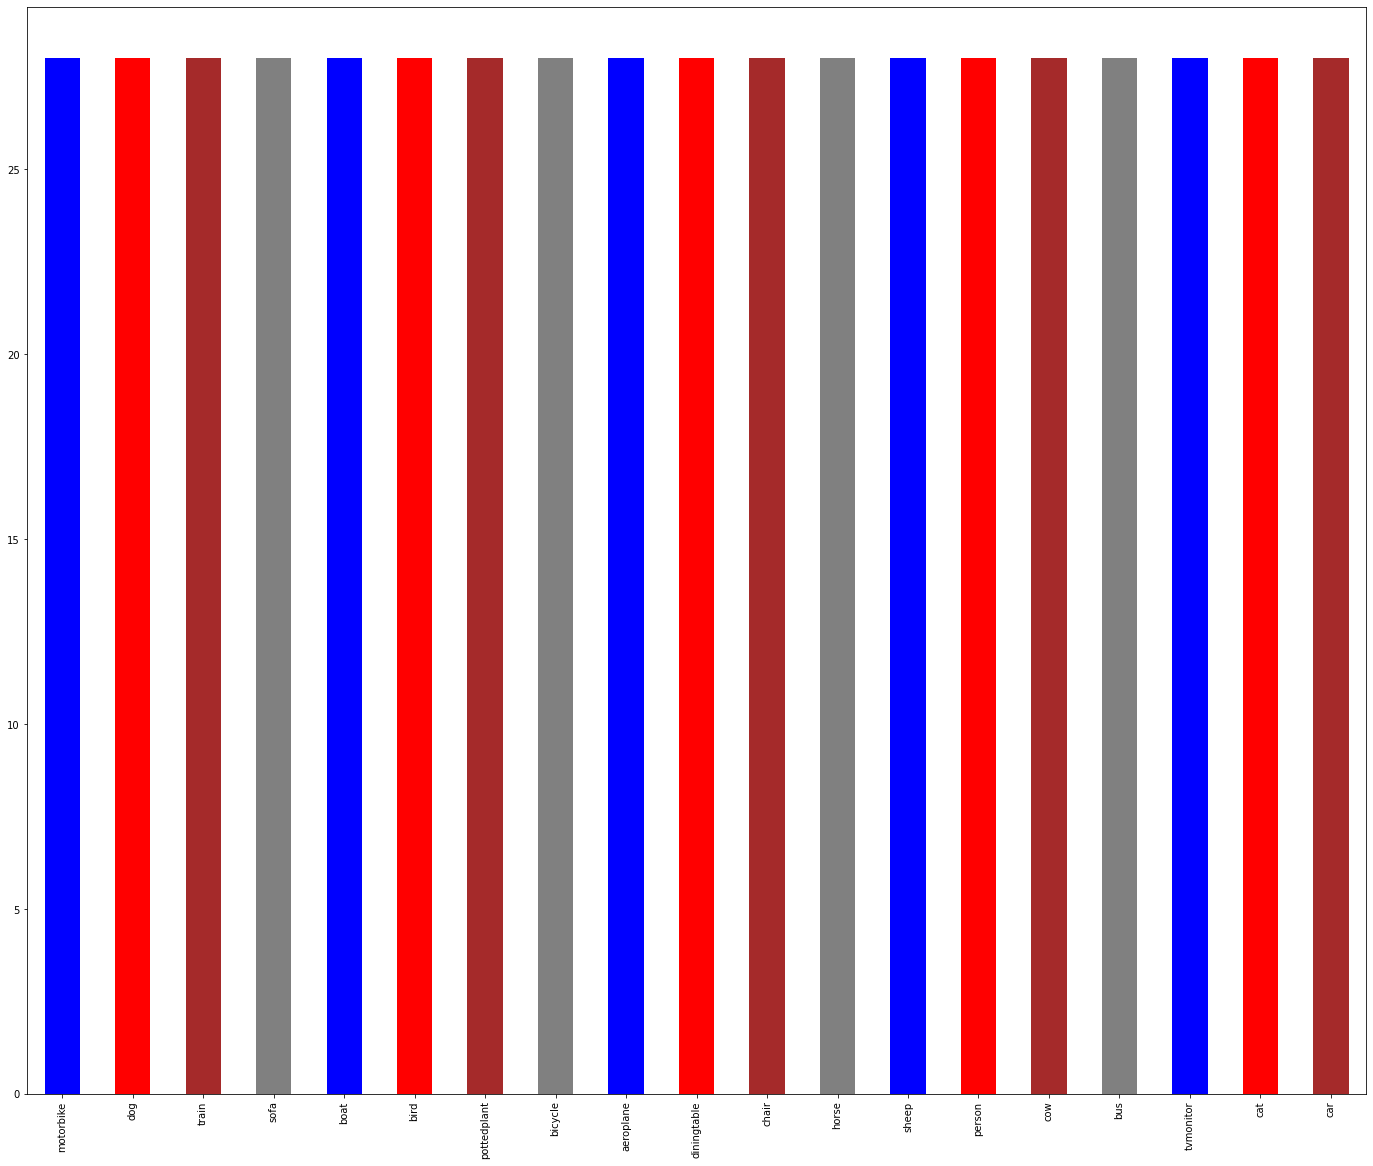

In [ ]:
plt.figure(figsize=(24,20))
X_train.tags.value_counts().plot(kind='bar', color=['Blue', 'Red', 'Brown', 'Gray']);

We can confirm visually that our dataset is balanced

## Keras

In [ ]:
print(f"train size: {len(X_train)}")
print(f"test size: {len(X_test)}")

train size: 532
test size: 380


in both encoder and tokenizer we only fit on train for consistency

In [ ]:
le = LabelEncoder()
le.fit(X_train['tags'])
y_train = le.transform(X_train['tags'])
y_test = le.transform(X_test['tags'])

In [ ]:
print(f'shape of new y_train is: {y_train.shape}')
print(f'shape of new y_test is: {y_test.shape}')

shape of new y_train is: (532,)
shape of new y_test is: (380,)


Convert the enoded y_train and y_test to one-hot representation

In [ ]:
num_tags = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_tags)
y_test = utils.to_categorical(y_test, num_tags)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
print(f'shape of new x_train is: {x_train.shape}')
print(f'shape of new x_test is: {x_test.shape}')
print(f'shape of new y_train is: {y_train.shape}')
print(f'shape of new y_test is: {y_test.shape}')

NameError: ignored

Let's set our hyperparameters  
we will adjust these later to, if possible, reach higher accuracy

In [ ]:
batch_size = 16
epochs = 12

Buliding the model

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_tags))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

we have the model, train and test data prepared  
so let's train the model

In [ ]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_split=0.1)

ValueError: ignored

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print(f'Test score:{score[0]}')
print(f'Test accuracy:{score[1]}')

In [ ]:
txt_lbls = le.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = txt_lbls[np.argmax(prediction)]
    print(X_test['captions'].iloc[i][:50], "...")
    print('Actual label:' + X_test['tags'].iloc[i])
    print("Predicted label: " + predicted_label + "\n")

In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
y_sm = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_sm)):
    probs = y_sm[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=txt_lbls, title="Confusion matrix")
plt.show()